# Larval Mushroom Body
The code below will load the connectome of the mushroom body of a _Drosophila_ larva. In the end, there will be a pair of `pandas` DataFrames and a `networkx` DiGraph.

If any of `bokeh`, `ipyvolume`, or `colorcet` don't load, you can safely comment out (or delete) those lines -- those packages are not necessary to do any of the analyses we've discussed. They could be useful for visualization down the road, so it's worth trying to install at least some of them.

Data from the paper `The complete connectome of a learning and memory centre in an insect brain. Nature. 2017 August 09; 548(7666): 175–182. doi:10.1038/nature23455`

In [6]:
import os, sys
import datetime
import time
import pandas as pd
import numpy as np
import networkx as nx
from scipy import sparse as sp

# from itertools import combinations, combinations_with_replacement
# from functools import reduce

import matplotlib.pyplot as plt

import bokeh
from bokeh.io import output_notebook, output_file, show, save
from bokeh.plotting import figure
from bokeh.models import (Rect, MultiLine, Circle, Span, Label,
                          GraphRenderer, StaticLayoutProvider,
                          NodesAndLinkedEdges,
                          HoverTool, TapTool, ColumnDataSource,
                          LinearColorMapper, LogColorMapper, BoxSelectTool,
                          ColorBar, BasicTicker, BoxZoomTool, FactorRange)
from bokeh.models import CategoricalTicker, FixedTicker, BoxAnnotation
from bokeh.models import Arrow, NormalHead, OpenHead, VeeHead, LabelSet

from bokeh.transform import transform, factor_cmap, linear_cmap, log_cmap
from bokeh.layouts import row, column, gridplot
output_notebook()

import ipyvolume as ipv

import colorcet as cc

def log_msg(*args, out=sys.stdout, **kwargs):
    """Print message m with a timestamp if out is not None."""
    if out:
        print(datetime.datetime.now().strftime("%Y %m %d %H:%M:%S "), *args, **kwargs, file=out)




log_msg("Imports complete")

log_msg("Reading neuron information from larval_MB/skeletons.csv")
larval_MB_skeletons = pd.read_csv("larval_MB/skeletons.csv")
larval_MB_skeletons.columns = [c.strip() for c in larval_MB_skeletons.columns]
larval_MB_skeletons.parent_treenode_id.fillna(-1, inplace=True)
larval_MB_skeletons.parent_treenode_id = larval_MB_skeletons.parent_treenode_id.astype(int)

log_msg("'skeleton_id' is the unique ID number for each neuron")
log_msg("'treenode_id' gives an idea of the size of the neuron (not an exact correspondence)")
log_msg("'x','y','z' are the coordinates of the centroid of the neuron")
larval_neuron_df = larval_MB_skeletons.groupby("skeleton_id").agg({"neuron":"first", "treenode_id":"count", "x":"mean", "y":"mean", "z":"mean"})
# larval_neuron_df #.reset_index().set_index("skeleton_id")
# with pd.option_context("display.max_rows",1000):
display(larval_neuron_df)

log_msg("Reading synapse data from larval_MB/synapses.csv")
larval_synapse_df = pd.read_csv("larval_MB/synapses.csv")
log_msg("Aggregating synapses into weighted graph")
weighted_edges = larval_synapse_df.groupby(['pre_skeleton_id', 'post_skeleton_id']).agg({'pre_treenode_id':'count'})
weighted_edges = weighted_edges.rename(columns={'pre_treenode_id':'weight'}).reset_index()
display(weighted_edges)
# .to_csv('larval_MB/weighted_edges.csv', index=False)

log_msg("Generating networkx directed graph")
g = nx.from_pandas_edgelist(weighted_edges,
                            source="pre_skeleton_id",
                            target="post_skeleton_id",
                            edge_attr=["weight"],
                            create_using=nx.DiGraph)

Loading BokehJS ...

2022 08 12 13:16:06  Imports complete
2022 08 12 13:16:06  Reading neuron information from larval_MB/skeletons.csv
2022 08 12 13:16:06  'skeleton_id' is the unique ID number for each neuron
2022 08 12 13:16:06  'treenode_id' gives an idea of the size of the neuron (not an exact correspondence)
2022 08 12 13:16:06  'x','y','z' are the coordinates of the centroid of the neuron


,neuron,treenode_id,x,y,z
skeleton_id,,,,,
29,KC #0 #29,2955,31438.829002,24738.514146,44077.377327
677717,KC1 #677717,2202,31859.598501,23931.804768,45046.389646
2506050,DAN-f1 right #2506050,5820,39767.371186,25165.836804,37174.785223
2612527,mPN iACT C2 mPN iACT C2 left #2612527,4963,73652.089119,52960.231211,48689.502317
2921933,V1: possible PVL005 - 3 Right? #2921933,2983,22915.473416,22456.512504,59368.488099
...,...,...,...,...,...
17476934,KC very young #17476934,14,31299.242857,8498.700000,66775.000000
17476964,KC very young #17476964,8,31566.600000,7060.875000,64100.000000
17476975,KC very young #17476975,2,32269.600000,6718.400000,63300.000000


2022 08 12 13:16:06  Reading synapse data from larval_MB/synapses.csv
2022 08 12 13:16:06  Aggregating synapses into weighted graph


,pre_skeleton_id,post_skeleton_id,weight
0,29,2506050,2
1,29,3234817,10
2,29,3299214,4
3,29,3347834,8
4,29,3522293,8
...,...,...,...
38759,19276024,3756659,1
38760,19276024,4152020,2
38761,19276024,4391978,1
38762,19276024,7020344,1


2022 08 12 13:16:06  Generating networkx directed graph


In [9]:
import plotly.graph_objects as go
# plot the mushroom body in 3D

fig = go.Figure(data=[go.Scatter3d(x=larval_neuron_df['x'], y=larval_neuron_df['y'], z=larval_neuron_df['z'],
                                   mode='markers')])
fig.show()

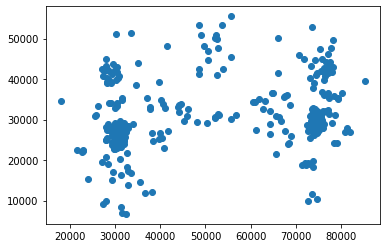

In [10]:
plt.scatter(larval_neuron_df['x'], larval_neuron_df['y'])

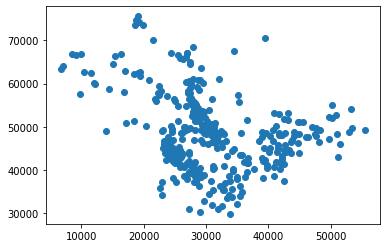

In [12]:
plt.scatter(larval_neuron_df['y'], larval_neuron_df['z'])

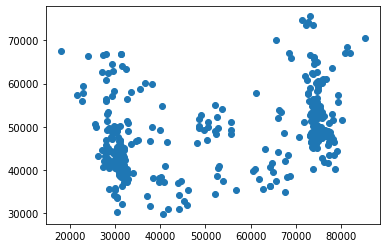

In [13]:
plt.scatter(larval_neuron_df['x'], larval_neuron_df['z'])

In [18]:
table=pd.read_csv('larval_MB/connectivity matrix table 1.csv')

In [19]:
del table['Unnamed: 0']

In [20]:
A= table.values

In [21]:
A

array([[0, 0, 0, ..., 0, 0, 2],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 3, 0],
       [2, 0, 0, ..., 0, 0, 1],
       [0, 2, 0, ..., 0, 1, 0]])

In [22]:
overall_connection=A+A.T

In [26]:
e_val, e_vec= np.linalg.eigh(overall_connection)

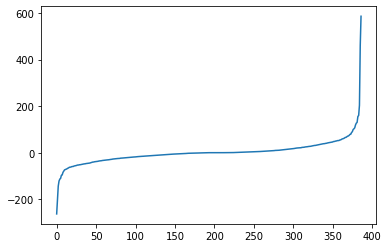

In [28]:
plt.plot(e_val)

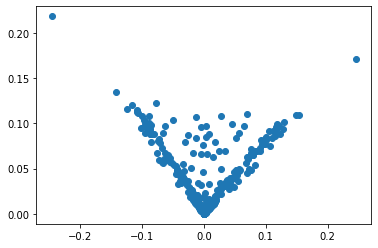

In [46]:
plt.scatter(e_vec[:,385],e_vec[:,386])

In [47]:
e_vec[:,370:386]

array([[ 2.30959180e-03, -1.23408588e-02,  1.56858727e-02, ...,
         2.84033223e-03, -2.10151535e-02,  8.92897903e-03],
       [-1.76226256e-02,  1.07068719e-04,  1.31890790e-02, ...,
         2.56552747e-02, -1.75873931e-02, -4.85807046e-03],
       [-4.62039523e-02,  5.19443092e-03, -2.13971879e-02, ...,
        -4.31917564e-03, -1.10450988e-02,  8.58277100e-03],
       ...,
       [ 1.74692602e-01,  2.85465388e-02, -2.18101460e-02, ...,
        -1.36524429e-02, -2.51220517e-02,  2.73797396e-02],
       [ 4.22515805e-02,  1.87517914e-02, -6.94997482e-02, ...,
         1.37707661e-01, -1.82692705e-01, -7.75933254e-02],
       [-1.63018031e-02, -1.34567024e-02,  1.02440585e-01, ...,
         1.33207515e-01, -1.83322560e-01,  7.01801062e-02]])